In [913]:
#Packages to be loaded. Probably there are duplicated or missing ones
import cobaya
import camb
import numpy as np
import sympy
import math
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import scipy.integrate as integrate

# Cosmological parameters #

In [914]:
#Cosmological constants
c = 2.99792458E5;   HJPAS = 1/(c/100);

#Parameteres that won't be sampled
gamma = 0.545; OmegakJPAS = 0; AsJPAS = 2.09052E-9; nsJPAS = 0.9626; tauJPAS = 0.06; mnuJPAS = 0.0;

#A set of cosmological parameters outside the fiducial cosmology
hJPAS = 0.6738
OmegabJPASh2 = 0.0225937
OmegaCDMJPASh2 = 0.1212
OmegamJPAS = 0.3135858601477107;

#Indirect cosmological parameters outside the fiducial
H0JPAS = hJPAS*100
OmegabJPAS = OmegabJPASh2/hJPAS**2; OmegaCDMJPAS = OmegaCDMJPASh2/hJPAS**2;
OmegaLJPAS = 1 - OmegamJPAS;

In [915]:
#Fiducial cosmology functions and constants
OmegamFid = 0.31417

#At z=1.7 (first bin)
EzFid = 2.6210003
XiFid = 3263.07985798
DAFid = 1208.54809555

# k and z binning #

In [916]:
#Arrays limits and steps.

#K arrays. In h units

kminKArrayCompleto = 0.001;   kmaxKArrayCompleto = 2.4900;  pasoKArrayCompleto = 0.025;
zmin = 1.7;   zmax = 2.9;   pasoz = 0.2;

#k binning, complete and in a reduced scaleset
KArrayCompleto = np.exp(np.arange(math.log(kminKArrayCompleto), math.log(kmaxKArrayCompleto), pasoKArrayCompleto) )
KArray = KArrayCompleto[range(121,246)]

#k binning on lower and upper limits
KArrayUpper = np.zeros(len(KArray)); KArrayLower = np.zeros(len(KArray));

for i in range(0, len(KArray)-1):
    KArrayUpper[i] = KArray[i] + (KArray[i+1]-KArray[i])/2;   KArrayLower[i] = KArray[i] - (KArray[i+1]-KArray[i])/2;

KArrayUpper[-1] = KArrayUpper[-2];  KArrayLower[-1] = KArrayLower[-2];


#z binning

#Original one
zaAntes = np.arange(zmin-0.1, zmax+pasoz/2, pasoz)

#Including z=0
zaAdicional = np.array([0])

#Binning including all lower and upper z-bins limits
zaConBines = np.arange(zmin-pasoz/2, zmax+0.01+pasoz/2, pasoz/2)

#z binning with 0 and including z-bin limits
za = np.concatenate((zaAdicional,zaConBines))

#Positions of upper and lower limits of the z-bins in the za array
positions_Upper = [3, 5, 7, 9, 11, 13, 15]
positions_Lower = [1, 3, 5, 7, 9, 11, 13]

# P(k) data and densities reading #

In [917]:
# Define a class to read the simulated data specifying the path as input
def read_data(path_to_data):
    data = {}

    Simulated_pk_filename = path_to_data+'Pk_Simulated_Data_HighZ_NoFeature.dat'
    Simulated_densities = path_to_data+'Densities_HighZ.dat'

    data['pkz'] = np.zeros((len(zaAntes), len(KArray)))
    data['ndz'] = np.zeros(len(zaAntes))
  
    with open(Simulated_pk_filename) as file:
        for i in range(len(KArray)):
            line = file.readline().split()
            data['pkz'][0][i] = float(line[2])
            data['pkz'][1][i] = float(line[3])
            data['pkz'][2][i] = float(line[4])
            data['pkz'][3][i] = float(line[5])
            data['pkz'][4][i] = float(line[6])
            data['pkz'][5][i] = float(line[7])
            data['pkz'][6][i] = float(line[8])

    with open(Simulated_densities) as file:
        for i in range(len(zaAntes)):
            line = file.readline().split()
            data['ndz'][i] = float(line[1])

    return data

# Read data is converted in the dictionary 'data'
data = read_data('/Users/guillermo/Desktop/')
data.keys()

dict_keys(['pkz', 'ndz'])

# CAMB settings and results #

In [918]:
# Let's try to obtain a PPS and Pm with nodes using CAMB

#Nodes value test
nodes_log_k = [np.log(KArray[0]), np.log(KArray[-1])]
nodes_log_PPS = [np.log(2.172477426329469), np.log(1.9795473104114968)]

#Undo the logs
nodes_k = np.exp(nodes_log_k)
nodes_PPS = np.exp(nodes_log_PPS)*1e-9

#Node interpolation. With just 2, kind always linear
NodesInterpFunc = interp1d(nodes_k, nodes_PPS,
                axis=0,  #This command interpolates among columns
                bounds_error=False,
                kind='linear',
                fill_value=(nodes_PPS[0], nodes_PPS[-1]))


#Parameter set 'pars' for CAMB, with its cosmology, a modified PPS and a P(m) including the nodes
from camb import model

pars = camb.CAMBparams()
pars.set_cosmology(H0=H0JPAS, ombh2=OmegabJPASh2, omch2=OmegaCDMJPASh2, mnu=mnuJPAS, omk=OmegakJPAS, tau=tauJPAS)
pars.max_eta_k = 5000.0
pars.YHe = 0.24597825866420944
#pars.InitPower.set_params(As=AsJPAS, ns=nsJPAS, r=0)
pars.InitPower = camb.initialpower.SplinedInitialPower()
pars.InitPower.set_scalar_log_regular(KArray[0], KArray[-1], NodesInterpFunc(KArray))
pars.set_matter_power(redshifts=za, kmax=10)
pars.NonLinear = model.NonLinear_none

Note: redshifts have been re-sorted (earliest first)


In [919]:
pars

class: <CAMBparams>
 WantCls = True
 WantTransfer = True
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_none
 Transfer: <TransferParams>
   high_precision = True
   accurate_massive_neutrinos = False
   kmax = 10.0
   k_per_logint = 0
   PK_num_redshifts = 16
   PK_redshifts = [3.000000000000001, 2.9000000000000012, 2.8000000000000007, 2.700000000000001, 2.6000000000000005, 2.500000000000001, 2.4000000000000004, 2.3000000000000007, 2.2, 2.1000000000000005, 2.0, 1.9000000000000001, 1.8, 1.7, 1.5999999999999999, 0.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2500
 max_l_tensor = 600
 max_eta_k = 5000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.0225937
 omch2 = 0.1212
 omk = 0.0
 omnuh2 = 0.0
 H0 = 67.38
 TCMB = 2.7255
 YHe = 0.24597825866420944
 num_nu_massless = 3.044
 num_nu_massive = 0
 nu_mass_eigenstates = 0
 share_del

In [920]:
#CAMB matter power spectrum Pm(k) with the nodes methodology included.

results = camb.get_results(pars) #Resultados de CAMB
kCAMB, zCAMB, pCAMB = results.get_matter_power_spectrum(minkh=KArray[0], maxkh=KArray[-1], npoints = len(KArray))


Text(0.5, 1.0, 'P_m(k) at z = 1.7 CAMB')

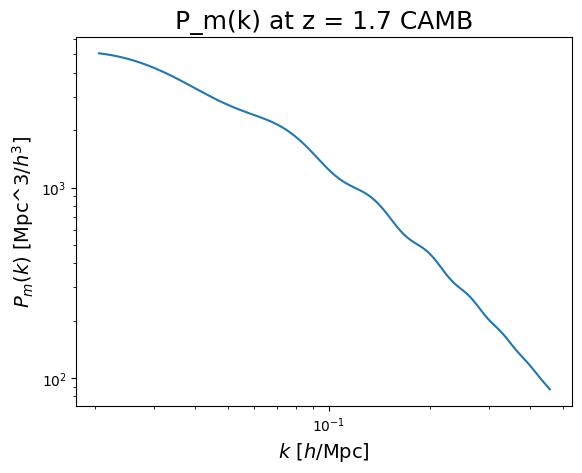

In [921]:
plt.loglog(kCAMB, pCAMB[2])
plt.ylabel('$P_m(k)$ [Mpc^3/$h^3$]',fontsize=14)
plt.xlabel('$k$ [$h$/Mpc]' ,fontsize=14);
plt.title('P_m(k) at z = 1.7 CAMB',fontsize=18)

# Classes to interface with Cobaya #

In [922]:
#If previous is OK, now the classes to interface with Cobaya are created.

#A cobaya theory NodesInPrimordialPk and a cobaya external likelihood Pklike classes are created

#Needed packages
from cobaya.theory import Theory
from cobaya.likelihood import Likelihood

In [923]:
#Class of the theory, with the PPS modification including the nodes
class NodesInPrimordialPk(Theory):

    def initialize(self): #Initialize self with the k-array
        self.ks = KArray

    #It seems that in here we allocate the values of the parameters to be sampled and definme their names
    def calculate(self, state, want_derived=True, **params_values_dict):
        
        #pivot_scalar = 0.05   #k pivot value
        
        nodes_k = [params_values_dict['k1'], params_values_dict['k2']] 
        nodes_PPS = [params_values_dict['P1'], params_values_dict['P2']] 

        
        #nodes_k and nodes_PPS are interpolated
        NodesInterpFunc_nodes = interp1d(nodes_k, nodes_PPS,
                axis=0,  # interpolate along columns
                bounds_error=False,
                kind='linear',
                fill_value=(nodes_PPS[0], nodes_PPS[-1]))
        
        #The PPS(k) is evaluated at our array of k
        state['primordial_scalar_pk'] = {'kmin': KArray[0], 'kmax': KArray[-1],
                                         'Pk': NodesInterpFunc_nodes(KArray), 'log_regular': True}

    #To be able to evaluate the PPS?
    def get_primordial_scalar_pk(self):
        return self.current_state['primordial_scalar_pk']
   
    #Function that returns the nodes parameters values
    def get_can_support_params(self):
        return ['k1', 'k2', 'P1', 'P2']


In [924]:
#Class incorporating the monopole and the likelihood. 


class Pklike(Likelihood): #Class is defined
    
    def initialize(self):  

        #Path in wich the data are. We call read_data with this path.
        self.data = read_data('/Users/guillermo/Desktop/')

        #Grid of K
        self.ks = KArray
        
        #Grid of z to be employed
        self.z_winCompleto = za

        #Grid of z with 100 bins
        #self.z_winExtended = np.linspace(0, 3, 100)


    
    def get_requirements(self): #¿Por qué es necesario tener requisitos? ¿No puedo usar las funciones sin esto?
                                #¿Interpolator en extended o completo?
        
        return {'omegam': None,                
                'Pk_interpolator': {'z': self.z_winCompleto, 'k_max': 10, 'nonlinear': False, 'vars_pairs': ([['delta_tot', 'delta_tot']])},
                'comoving_radial_distance': {'z': self.z_winCompleto},
                'angular_diameter_distance': {'z': self.z_winCompleto},
                'Hubble': {'z': self.z_winCompleto, 'units': 'km/s/Mpc'},
                'sigma8_z': {'z': self.z_winCompleto}, 'fsigma8': {'z': self.z_winCompleto},
                 #'fsigma8': {'z': self.z_win, 'units': None},
                'CAMBdata': None}
 
    #Definition of the monopole. It will return:
        #The monopole evaluated at z=1.7 and array of k
        #The covariance evaluated at z=1.8 and array of k
    
    def monopole(self, **params_dic):

        resultsCobaya = self.provider.get_CAMBdata()   #CAMB results in results   
        
        # All functions and variables to compute the Kaiser model
        Omegam = self.provider.get_param('omegam')  
        Ez = np.sqrt( Omegam*(1+self.z_winCompleto)**3+(1-Omegam) ); 
        H = HJPAS * Ez
        f = (Omegam*(1+self.z_winCompleto)**3*1/(Ez**2))**gamma
        sigma8 = self.provider.get_sigma8_z(self.z_winCompleto)
        De = self.provider.get_sigma8_z(self.z_winCompleto)/sigma8[0]
        
        def bJPAS(z):
          return 0.53+0.289*(1+z)**2
            
        A = bJPAS(za)*sigma8
        R = f*sigma8
        # This is the matter power spectrum interpolator:
        pkCobaya = self.provider.get_Pk_interpolator(('delta_tot', 'delta_tot'), nonlinear=False)    #P matter is obtained here
        print(pkCobaya.P(self.z_winCompleto[2],self.ks))
        
        # Photometric factor
        DeltazJPAS = 0.00364236313918151
        sigmar = DeltazJPAS*(1+self.z_winCompleto)/H

        # Fingers of God effect
        sigmap = (   1/(6*np.pi**2)*integrate.quad(lambda k: pkCobaya.P(self.z_winCompleto[2],k) , self.ks[0], self.ks[-1])[0]  )**0.5

        
        def FFog(mu,k):
            return 1/(1+(f[2]*k*mu*sigmap)**2)

        # AP effect
        Xi = self.provider.get_comoving_radial_distance(self.z_winCompleto)*hJPAS;
        DA = Xi/(1+self.z_winCompleto);
        FactorAP = DAFid**2*Ez[2]/( DA[2]**2*EzFid )

        def Q(mu):
            return ((Ez[2]**2*Xi[2]**2*mu**2-EzFid**2*XiFid**2*(mu**2-1))**0.5/(EzFid*Xi[2]))
 
        def muObs(mu):
            return mu*Ez[2]/(EzFid*Q(mu))
           
        def kObs(mu,k):
            return Q(mu)*k 


        #P galaxy
        def Pg(mu,k):
            return FactorAP*FFog(muObs(mu),kObs(mu,k))*(A[2]+R[2]*muObs(mu)**2)**2 * pkCobaya.P(self.z_winCompleto[2],kObs(mu,k))/sigma8[2]**2 *np.exp(-(k*mu*sigmar[2])**2)

        #Trapezoid rule with 2000 steps for computing the Pmonopole(k)
        def Pgmonopole(k):
            mu = np.arange(-1, 1, 1/1000)
            return 1/2 * integrate.trapz(Pg(mu, k), mu)

        PgmonopoleValores = np.zeros(len(self.ks))

        for i in range(0, len(self.ks)):
             PgmonopoleValores[i] = Pgmonopole(self.ks[i])

        
        #Covariance
        
        #Densities are red from self.data['ndz].

        #Definition of the volume (requires angular distance and za lower/upper bining)
        #Area of the sky
        fsky = 0.2575;

        #Angular distance for z upper and lower bins. Not exactly equal to my previous example?

        XiZaLower = self.provider.get_comoving_radial_distance(self.z_winCompleto[positions_Lower])*hJPAS
        XiZaUpper = self.provider.get_comoving_radial_distance(self.z_winCompleto[positions_Upper])*hJPAS
        
        #Definition of the volume between redshift bins
        Vol = 4*np.pi*fsky/3*(XiZaUpper**3-XiZaLower**3)
   
        #Number of modes. It depends of ksup and kinf corresponding to kupper y klower
        def Nk(ksup,kinf):
            return Vol[0] * (4*np.pi/3*(ksup**3-kinf**3))/((2*np.pi)**3)

        #Nk evaluated for each of our k-bins
        NkEvaluado = np.zeros(len(self.ks))
        for i in range(0, len(self.ks)):
            NkEvaluado[i] = Nk(KArrayUpper[i],KArrayLower[i])
        
        #Covariance Cov definition
        def Cov(k,k1,k2):
            return 2 * (Pgmonopole(k) + 1/self.data['ndz'][0])**2 / Nk(k1,k2)
    
        #Cov evaluated at our k array
        CovEvaluado = 2 *(PgmonopoleValores + 1/self.data['ndz'][0])**2 / NkEvaluado

        #We return the value of the monopole at our k-array and of the Covariance Matrix at the same array
        return PgmonopoleValores, CovEvaluado


    #Likelihood calculation
    
    def logp(self, **params_values):       
        
        #For allocating the monopole values and cov valued

        PMonopoleBineado = np.zeros((7, len(self.ks)))
        CovBineado = np.zeros((7, len(self.ks)))

        #PMonopoleBineado and CovBineado are equal to the values given by the self.monopole
        PMonopoleBineado[0, :len(self.ks)],CovBineado[0, :len(self.ks)] = self.monopole(**params_values)
        
        #Likelihood is constructed, with j being the z-array value, and i the k-array value.
        #Now we work with just j=0, corresponding to the first z-bin 1.7

        #Likelihood similar to an chi^2. Factor of log cov?
        def lnlikeSinSumar(j,i):
            return (PMonopoleBineado[j][i] - data['pkz'][0][i])**2 * 1/CovBineado[j][i]
            #return (self.monopole(**params_values)[0][i]-data['pkz'][0][i])**2 * 1/CovBineado[j][i] + np.log(CovBineado[j][i])
            # return(PgBineado[j][i]-data['pkz'][0][i])**2 * 1/CovBineado[j][i] + np.log(CovBineado[j][i])

        #Indices in which we sum over the likelihood values. We use all of them
        IndicesLikelihood = np.arange(0,len(self.ks),1)

        #Final likelihood value
        lnlike = np.sum(lnlikeSinSumar(0,IndicesLikelihood))
        
        print(lnlike)
        
        return lnlike


In [925]:
# Input given to Cobaya.

# We define the dictionary 'info' including all our information, including the likelihood, theory (with the monopole)
# and the priors

info = {'debug': False,                        #Allow to debug
        'likelihood': {'jpass': Pklike},      #Link likelihood (nombre jpass) with the previously defined class?
        'theory': {'camb': {"external_primordial_pk": True},
                   'my_pk': NodesInPrimordialPk},      #Theory class, with the name "my_pk".
       'params': {
           
        # Fixed cosmological parameters
        'tau': 0.06, 'mnu': 0.00, 'nnu': 3.046, 'k1': KArray[0], 'k2': KArray[-1],
        #'P1': 2.2e-9, 'P2': 2.0e-9, 'ombh2': OmegabJPASh2Fid, 'omch2': OmegaCDMJPASFid, 'H0': hJPASFid*100}
           
        # Parameters of the nodes, with flat priors
        'P1': {'prior': {'min': 18e-10, 'max': 2.2e-9}, 'latex': 'P_1'},
        'P2': {'prior': {'min': 18e-10, 'max': 2.2e-9}, 'latex': 'P_2'},
           
        # Cosmological parameters to be sampled. Loc y scale are the mean value and the st deviation in a guassian prior
        'ombh2': {'prior': {'dist': 'norm', 'loc': OmegabJPASh2, 'scale': 0.00015}, 'latex': 'Omega_bh^2'},
        'omch2': {'prior': {'dist': 'norm', 'loc': OmegaCDMJPASh2, 'scale': 0.0012}, 'latex': 'Omega_ch^2'},
        'H0': {'prior': {'dist': 'norm', 'loc': H0JPAS, 'scale': 0.54}, 'latex': 'H_0'}},

        "sampler": {"polychord": None}}
        #'sampler': {
            #'evaluate': {
                #'override': {
                   #'P1': 2.2e-9, 'P2': 2.0e-9, 'ombh2': OmegabJPASh2Fid, 'omch2': OmegaCDMJPASFid, 'H0': hJPASFid*100}}}
       #}

In [926]:
# Let's reproduce the same matter power spectrum as the one by single camb through the cobaya interface

from cobaya.model import get_model     
model = get_model(info)          #A model is constructed with the 'info' dictionary

fixed_values = {'tau': tauJPAS, 'mnu': mnuJPAS, 'nnu': 3.046, 'k1': KArray[0] , 'k2': KArray[-1],
    'P1': 2.172477426329469e-09, 'P2': 1.9795473104114968e-09, 'H0': H0JPAS, 'ombh2': OmegabJPASh2,
    'omch2': OmegaCDMJPASh2}

model.logposterior(fixed_values)          #Esto?

camb_results = model.provider.get_CAMBdata();  #Esto?

pk_matter_Cobaya = model.provider.get_Pk_interpolator(('delta_tot', 'delta_tot'), nonlinear=False) #Y esto?


[model] *WARNING* Ignored blocks/options: ['sampler']
[camb] `camb` module loaded successfully from /Users/guillermo/Desktop/code/CAMB/camb
[13724.65246812 13464.3078301  13198.4778499  12928.85517982
 12656.50682514 12382.55770848 12108.40226886 11835.17070856
 11562.94717727 11292.08624785 11024.52458103 10762.90519691
 10508.37598194 10262.11081621 10025.17047662  9798.32679895
  9582.11860754  9376.79939596  9182.3541155   8998.51799956
  8824.78592369  8660.44287133  8504.62957684  8356.43935737
  8214.9094449   8078.54228611  7950.10587     7831.64470585
  7713.05715378  7588.26177811  7459.67042287  7326.68229618
  7185.93638174  7035.47876682  6873.97366703  6700.27114555
  6513.97487656  6315.42656903  6105.68750969  5886.51235636
  5660.20582045  5429.49514034  5197.41078271  4967.17827994
  4742.14986664  4525.7221832   4321.20120515  4131.5932185
  3959.30204429  3805.82873665  3671.55183813  3555.65097941
  3456.20754915  3370.40741209  3294.73915275  3225.11535926
  3156.

Text(0.5, 1.0, 'P_m(k) at z = 1.7 Cobaya')

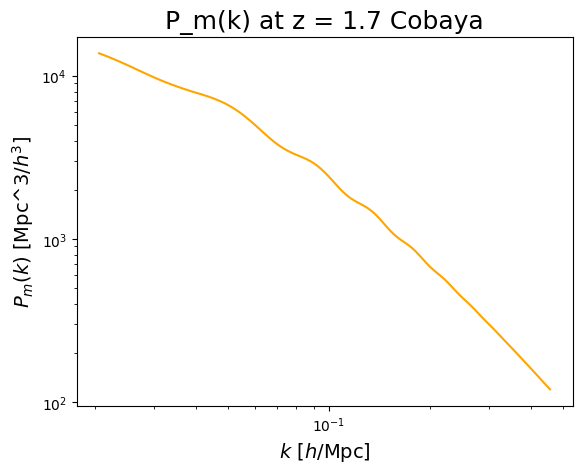

In [927]:
plt.loglog(KArray, pk_matter_Cobaya.P(za[2],KArray), color='orange')
plt.ylabel('$P_m(k)$ [Mpc^3/$h^3$]',fontsize=14)
plt.xlabel('$k$ [$h$/Mpc]' ,fontsize=14);
plt.title('P_m(k) at z = 1.7 Cobaya',fontsize=18)

In [928]:
#from cobaya import run
#updated_info, sampler = run(info)

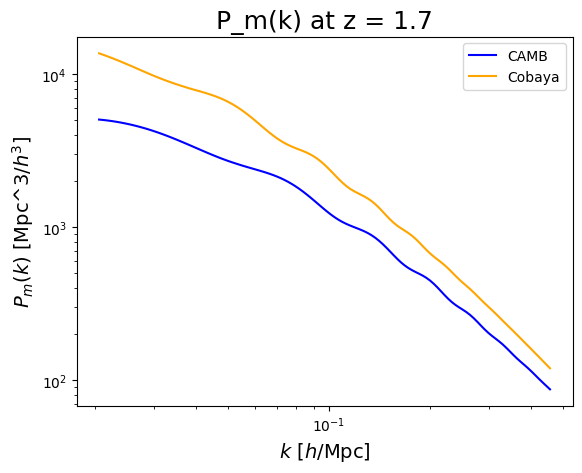

In [929]:
# Plotting both datasets with different colors
plt.loglog(kCAMB, pCAMB[2], label='CAMB', color='blue')
plt.loglog(KArray, pk_matter_Cobaya.P(za[2], KArray), label='Cobaya', color='orange')

# Adding labels and title
plt.ylabel('$P_m(k)$ [Mpc^3/$h^3$]', fontsize=14)
plt.xlabel('$k$ [$h$/Mpc]', fontsize=14)
plt.title('P_m(k) at z = 1.7', fontsize=18)

# Adding legend
plt.legend()

# Show the plot
plt.show()